<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/Plug_and_Play_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plug and Play optimization

## Introduction

Plug-and-play (PnP) is an optimization framework that integrates modern denoising priors into gradient or proximal descent schemes. 

The goal of this notebook is to use PnP methods to solve image restoration problems (interpolation of missing pixels, denoising, or deblurring for instance). Typically, these inverse problems can be written 
$$y = Mx+\eta$$
where $x$ is an unknown image that we wish to reconstruct, $y$ is the observed image, $M$ is a linear degradation operator and $\eta$ is a realization of a known noise distribution (for instance Gaussian). The discrete images $x$ and $y$ can be seen as vectors of size $n$ and $m$ (for instance by reading them columnwise), and $M$ is a $m\times n$ matrix. For instance, for an inverse problem where pixel values are missing, $M$ is a diagonal matrix with $0$ (hidden pixels) and $1$ (known pixels) on the diagonal.

To estimate $x$, when the noise is Gaussian, a classical approach consists in minimizing an energy of the form
$$ \frac{1}{2\sigma^2}\|Mx - y \|^2 +  U(x)$$  
where the second term is a regularization term on $x$.
In a Bayesian framework, this energy can be interpreted as 
$$-\log p(x|y) = -\log p(y|x)-\log p(x),$$ where $p(y|x) \propto e^{-\frac{1}{2\sigma^2}\|Mx - y \|^2}$ is the likelihood of $y$ knowing $x$ and a prior distribution $p(x) \propto e^{-U(x)}$ is assumed on the unknown $x$.

Typicall optimization schemes used to minimize the previous expression involve the gradient or proximal operator of $U$. The principle of PnP approaches is  to derive an approximation of $\nabla U$ or $prox_U$ using an image denoiser, for instance a denoising deep neural network. This approximation can then be used with any scheme using gradient or proximal descent on $U$ for optimization or sampling. 


This practical session explains and shows inpainting et deblurring experiments based on the code of the following paper:

[E. K. Ryu, J. Liu, S. Wang, X. Chen, Z. Wang, and W. Yin, Plug-and-Play Methods Provably Converge with Properly Trained Denoisers, in Proceedings of the 36th International Conference on Machine Learning, ICML 2019, 9-15 June 2019, Long Beach, California, USA, 2019, pp. 5546–5557](http://proceedings.mlr.press/v97/ryu19a.html)

**References:**
* Model and code for loading it: https://github.com/uclaopt/Provable_Plug_and_Play
* Notations for the notebook are the one of the paper [R.Laumont, V. de Bortoli, A. Almansa, J. Delon, A. Durmus, M. Pereyra, Bayesian imaging using Plug & Play priors: when Langevin meets Tweedie, 2022](https://arxiv.org/abs/2103.04715) 

**Authors of the notebook:**
* Lucía Bouza
* [Julie Delon](https://github.com/judelo)
* Rémi Laumont

## Environment setting

### Importing packages

Below is a list of packages needed. PyTorch version used to run this notebook is **1.11.0+cu113** (to check the installed version, use `torch.__version__`)

* `numpy`
* `matplotlib.pyplot` (display of images and graphics)
* `torch` (use cuda with PyTorch)
* `time` (measure time)
*  `os` (interactions with the operating system)

In [7]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import os
%matplotlib inline

To import the solutions, execute the following cell. If you are using a Windows system, comment the `wget` line, download the file by hand, and place it in the same folder as the notebook.

In [23]:
!wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/Restoration/Solutions/PnP.py
from PnP import *

--2023-01-02 13:43:20--  https://raw.githubusercontent.com/storimaging/Notebooks/main/Restoration/Solutions/PnP.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3398 (3.3K) [text/plain]
Saving to: ‘PnP.py’

PnP.py              100%[===================>]   3.32K  --.-KB/s    in 0s      

2023-01-02 13:43:20 (32.8 MB/s) - ‘PnP.py’ saved [3398/3398]



### Download code and models

In this notebook, for the sake of simplicity (and computing time!), we will use a pre-trained denoising networks. The `load_generic_denoiser` function helps to load the different models available:

- DnCNN with real spectral normalization (RealSN-DnCNN), presented in this [paper](http://proceedings.mlr.press/v97/ryu19a.html). The model was taken from the [original implementation](https://github.com/uclaopt/Provable_Plug_and_Play). 

- BF_CNN trained with different datasets, presented in this [paper](https://arxiv.org/abs/2007.13640 ). The model was taken from the [original implementation](https://github.com/LabForComputationalVision/universal_inverse_problem).


In `AuxiliarFunctions_PnP` we rewrite the `load_model` functions and define the networks for each case, taken from the original code.

In [8]:
#@title 
!wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/Restoration/AuxiliarFunctions/AuxiliarFunctions_PnP.py
from AuxiliarFunctions_PnP import *

--2023-01-02 13:36:09--  https://raw.githubusercontent.com/storimaging/Notebooks/main/Models/RealSN_DnCNN_noise5.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11028586 (11M) [application/octet-stream]
Saving to: ‘RealSN_DnCNN_noise5.pth.1’

RealSN_DnCNN_noise5 100%[===================>]  10.52M  --.-KB/s    in 0.07s   

2023-01-02 13:36:09 (148 MB/s) - ‘RealSN_DnCNN_noise5.pth.1’ saved [11028586/11028586]

File ‘AuxiliarFunctions_PnP.py’ already there; not retrieving.



In [75]:
def load_denoiser(name_denoiser, model_name, grayscale = True):
    os.system("wget https://raw.githubusercontent.com/storimaging/Notebooks/main/Models/" + model_name)

    if name_denoiser == "DnCNN":
       model = load_model_RYU(model_name)
    if name_denoiser == "BF_CNN":
       model = load_BF_CNN(model_name, grayscale = True)
    return model

# model_types options: [DnCNN, BF_CNN]
# model_name options: [RealSN_DnCNN_noise5.pth, BFCNN_BSD400_gray_noise0to100_model.pt, BFCNN_mnist_gray_noise0to100_model.pt]
model_type = "DnCNN"
model_name = "RealSN_DnCNN_noise5.pth"

model = load_denoiser(model_type, model_name)


### Performance measurement

In the following, we will compare several algorithms, in terms of computing time and performance. We will use the PSNR (defined below) to measure restoration performance. The higher the value, the better the result.

In [16]:
def PSNR(image_u, image_denoised, peak=1):
    
    return 10*np.log10(peak**2/np.mean((image_u-image_denoised)**2))

### Helper functions

In the next cell we will define some helper functions for displaying and creating degraded images. We will also define the Denoiser function to be used by all PnP implementations.

In [17]:
#@title

# Function to display two images
def printImages(a, b, title_a, title_b, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    fig.tight_layout()
    plt.show()


# Display time, PSNR and images
def displayResults(image_denoised, v, title_a, title_b, size1, size2, time, original):

    print("time: ", time)
    print("PSNR: ", PSNR(original, image_denoised))
    printImages(image_denoised, v, title_a, title_b, 10, 10)


# Create blurred image with periodic kernel
def CreateBlurredImage(u_orig, sigma,s):

    n_Rows, n_Cols = u_orig.shape
    b = sigma*np.random.randn(n_Rows,n_Cols)

    # Definition of the blurring kernel l_h
    k_uniform = np.zeros((n_Rows,n_Cols))
    k_uniform[0:2*s+1,0:2*s+1] = np.ones((2*s+1, 2*s+1))/(2*s+1)**2

    image = np.real(np.fft.ifft2(np.fft.fft2(u_orig)*np.fft.fft2(k_uniform))) + b

    return image, k_uniform


# Create image with missing pixels and noise
def CreateImageWithMissingPixels(u_orig, sigma,p):
        
    nrow,ncol = u_orig.shape
    # Create noise
    b = sigma*np.random.randn(nrow,ncol)
    # Create mask
    mask = np.random.rand(nrow,ncol)>p
    
    image = mask*u_orig + b
    return image, mask

## Algorithms

As explained above, we wish to solve  $$ \arg\min_x f(x) + \alpha U(x)$$

where,

- $x$ is an image
- $f(x)$ is a data fidelity term (corresponding to the logarithm of the likelihood)
- $U(x)$ is the image prior 
- $\alpha ≥ 0$ is the relative importance between $f$ and $g$

For convenience we can rewrite the minimization problem as: $$\arg\min_x \frac{1}{\alpha} f(x) + U(x).$$




### PnP ADMM

Recall the alternating directions method of multipliers (ADMM) optimization to solve the previous problem:

$$
x^{k+1} =Prox_{\frac \epsilon \alpha f}(y^k −u^k) \\
y^{k+1} = Prox_{\epsilon U} (x^{k+1} + u^k ) \\
u^{k+1} = u^k + x^{k+1} − y^{k+1} \\
$$

PnP-ADMM simply replaces the proximal operator $Prox_{\epsilon U}$ with the denoiser $D_{\epsilon}$, where $\epsilon$ is the noise parameter (variance) of the denoiser:

$$
x^{k+1} =Prox_{\frac \epsilon \alpha f}(y^k −u^k) \\
y^{k+1} = D_{\epsilon} (x^{k+1} + u^k ) \\
u^{k+1} = u^k + x^{k+1} − y^{k+1}. \\
$$


Write a function `pnp_admm` to implement the algorithm, with the following parameters:

```
def pnp_admm(noisy, denoiser, proximal_step, **opts):
    """
    Parameters:
        :noisy - the noisy observation.
        :denoiser - the Gaussian denoiser used in Plug-and-Play ADMM.
        :proximal_step - the function which implements the proximal step of the ADMM algorithm.
        :opts - the kwargs for hyperparameters in Plug-and-Play ADMM.
    """
```



### PnP FBS

The forward-backward splitting (FBS) optimization scheme can be written:

$ x^{k+1} = Prox_{\epsilon U}(I - \frac \epsilon \alpha \nabla f)(x^k) $

PNP-FBS simply replaces the proximal operator $Prox_{\epsilon U}$ with the denoiser $D_{\epsilon}$:

$ x^{k+1} = D_{\epsilon}(I - \frac \epsilon \alpha \nabla f)(x^k) $ 

Write a function `pnp_fbs` to implement the algorithm, with the following parameters:

```
def pnp_fbs(noisy, denoiser, proximal_step, **opts):
    """
    Parameters:
        :noisy - the noisy observation.
        :denoiser - the Gaussian denoiser used in Plug-and-Play FBS.
        :gradient_step - the function which implements the gradient step: x- alpha*grad(f)
        :opts - the kwargs for hyperparameters in Plug-and-Play FBS.
    """
```

### PnP BBS

A fully proximal version of the algorithm, called backward-backward splitting (BBS) writes:

$ x^{k+1} = Prox_{\epsilon U}(Prox_{\frac \epsilon \alpha f})(x^k) $

PNP-BBS replaces the proximal operator $Prox_{\epsilon U}$ with the denoiser $ D_{\epsilon}$:

$ x^{k+1} = D_{\epsilon}(Prox_{\frac \epsilon \alpha f})(x^k) $ 

Write a function `pnp_fbs` to implement the algorithm, with the following parameters:

```
def pnp_bbs(noisy, denoiser, proximal_step, **opts):
    """
    Parameters:
        :noisy - the noisy observation.
        :denoiser - the Gaussian denoiser used in Plug-and-Play BBS.
        :proximal_step - the function which implements the proximal step of the FBS algorithm.
        :opts - the kwargs for hyperparameters in Plug-and-Play BBS.
    """
```



Remark: it can be shown that PNP-FBS and PNP-ADMM are different methods for finding the same set of fixed points. Sometimes, PNP-FBS is easier to implement since it only requires the computation of $\nabla f$ rather than $Prox_{ f}$ . On the other hand, PNP-ADMM is generally more robust with better convergence properties. 
BBS aims at solving a slightly modified version of the original problem where $f$ is replaced by its Moreau envelope.

## Experiments

We will now use the previous algorithms to solve two inverse problems in imaging: deblurring and inpainting. 


### PnP for deblurring

In this section, experiments will be carried out to recover images with blur and additive noise. 
In the next cell we will define the algorithm's hyperparameters, load the denoiser model to use, and create a blurred image. In all cases we will use the denoising model developed by the authors (**RealSN_DnCNN**) with sigma level of 5. 

In [18]:
# Read image
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Images/main/img/simpson_nb512.png")
u_orig = plt.imread("simpson_nb512.png")

u_orig = u_orig[128:256,128:256]
# start by working with a small image to experiment, before using the whole image

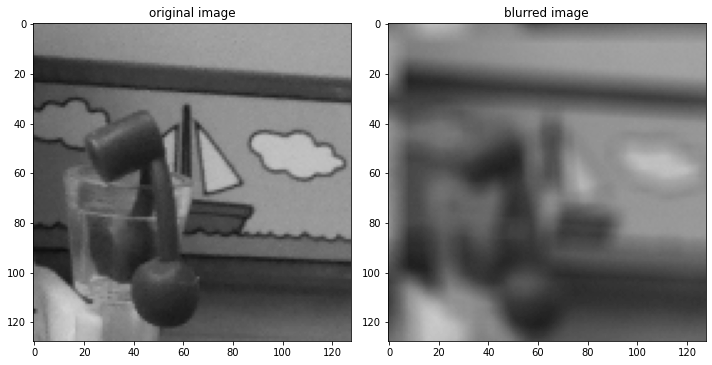

In [76]:
# Define hyperparameters
sigma = 1/255 #additive noise

# Create blurred image
blurredImage, H = CreateBlurredImage(u_orig, sigma,s=4)

# Display the degraded image 
printImages(u_orig, blurredImage, 'original image', 'blurred image', 10, 10)

To use the previous algorithms, we need to define the gradient and proximal steps for the data term of the deblurring problem. The data term can be written $$\frac 1 \alpha f(x) = \frac{|| Mx - y ||^2}{2 \alpha\sigma^2}$$
with,
- $M$ the degradation matrix (corresponding to a convolution with a kernel $h$)
- $y$ the observation
- $\sigma$ the standard deviation of the Gaussian additive noise for the given restoration problem.

Clearly, $$\nabla f(x) = M^*\frac{Mx -y}{\sigma^2}$$ and $$\mathrm{prox}_{\frac \epsilon \alpha f}(x) = (Id+\frac \epsilon {\alpha\sigma^2} M^* M)^{-1}\left(x +\frac \epsilon  {\alpha\sigma^2} M^* y\right).$$

The linear operator $M$ represents a convolution by a kernel $h$. It can be applied directly in the Fourier domain as a multiplication. The adjoint $M^*$ is the convolution with the conjugate of $h$.


In [20]:
# Define gradient step  
def grad_deblurring(x, im_b, **opts):
    """
    Gradient Operator for Gaussian deblurring:
    f(x) = || A.x - im_b ||^2 / (2 sigma^2) 
    with A.x = h*x
    Parameters:
        :x - the argument to the proximal operator.
        :im_b - the noisy observation.
        :h - blurring kernel.
        :sigma - the standard deviation of the gaussian noise in im_b.
        :alpha - the regularization parameter.
    """
    
    # Process Parameters
    alpha = opts.get('alpha', 1.)
    sigma = opts.get('sigma', 1/255)
    sigma_model = opts.get('sigma_model', 5)
    h = opts.get('h', np.ones_like(im_b))
    n_row = opts.get('n_row', 1)
    n_col = opts.get('n_col', 1)
    epsilon = (sigma_model/255)**2

    # Reshapes
    x_shapeOrig = np.reshape((x) , (n_row, n_col))
    im_b_shapeOrig = np.reshape((im_b) , (n_row, n_col))

    # Computes gradient step
    a = epsilon/(alpha*sigma**2)
    
    h_fft = np.fft.fft2(h)
    hc_fft = np.conj(h_fft)
    x_fft = np.fft.fft2(x_shapeOrig)
    grad = x_shapeOrig -a*np.real(np.fft.ifft2(hc_fft *(h_fft*x_fft - np.fft.fft2(im_b_shapeOrig))))

    # Reshape to flat to return
    return np.reshape(grad, -1)


def prox_deblurring(x, im_b, **opts):
    """
    Proximal Operator for Gaussian deblurring:
    f(x) = || A.x - im_b ||^2 / (2 sigma^2) 
    avec A.x = h*x
    prox_{alpha f} (x[i]) = 1/(1+alpha/sigma^2*h_fft*hc_fft)*(alpha/sigma^2 A.T im_b[i] +x[i]) 
    Parameters:
        :x - the argument to the proximal operator.
        :im_b - the noisy observation.
        :h - blurring kernel.
        :sigma - the standard deviation of the gaussian noise in im_b.
        :alpha - the regularization parameter.
    """
    
    # Process parameters
    alpha = opts.get('alpha', 1.)
    sigma = opts.get('sigma', 1/255)
    sigma_model = opts.get('sigma_model', 5)
    h = opts.get('h', np.ones_like(im_b))  
    n_row = opts.get('n_row', 1)
    n_col = opts.get('n_col', 1)
    epsilon = (sigma_model/255)**2

    # Reshapes
    x_shapeOrig = np.reshape((x) , (n_row, n_col))
    im_b_shapeOrig = np.reshape((im_b) , (n_row, n_col))
    
    # Computes proximal step
    a = epsilon/(alpha*sigma**2)
    
    h_fft = np.fft.fft2(h)
    hc_fft = np.conj(h_fft)
    
    X = a*np.real(np.fft.ifft2(hc_fft*np.fft.fft2(im_b_shapeOrig))) + x_shapeOrig
    prox = np.real(np.fft.ifft2(np.fft.fft2(X)/(a*h_fft*hc_fft + 1)))
    
    # Reshape to flat to return
    return np.reshape(prox, -1)

#### PnP ADMM

In the following cell we will define the function that implements the proximal step needed by **PnP ADMM**. Next, we will run the algorithm and display the result.


In [39]:
# Define hyperparameters
alpha = 0.6
maxitr = 100
sigma_model = 5 #(corresponds to sqrt(epsilon)*255)

# Kwargs for PnP algorithm
opts = dict(alpha=alpha, maxitr=maxitr, sigma_model=sigma_model, sigma=sigma, h=H, n_row=u_orig.shape[0], n_col=u_orig.shape[1])


time:  0.9187226295471191
PSNR:  23.728652604893323


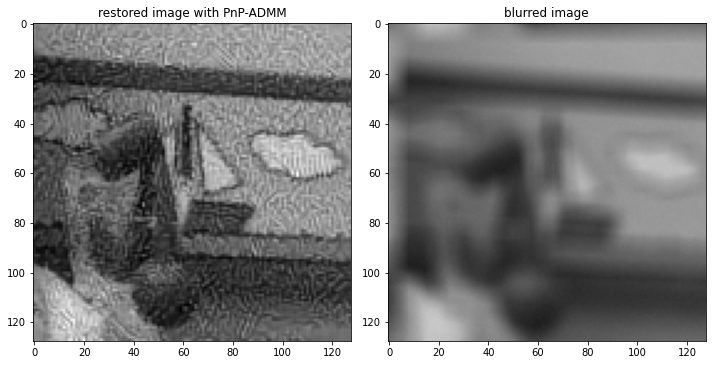

In [72]:
# Run the algorithm
with torch.no_grad():
    start = time.time()
    out = pnp_admm(blurredImage, model, prox_deblurring, **opts)
    end = time.time()

# Display results
displayResults(out, blurredImage, 'restored image with PnP-ADMM', 'blurred image', 10, 10, end - start, u_orig)

#### PnP-FBS

time:  0.6482930183410645
PSNR:  33.727400517417585


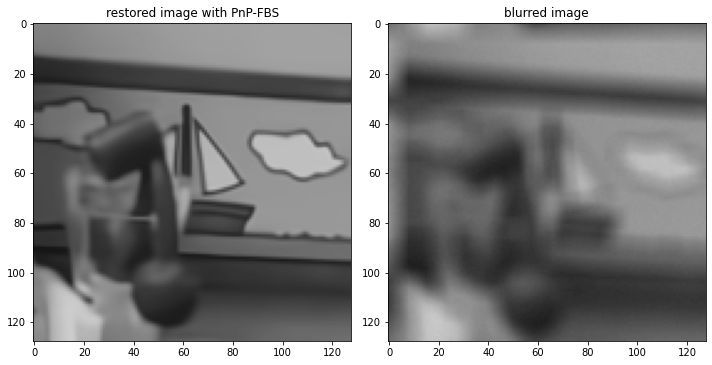

In [ ]:
# Run the algorithm
with torch.no_grad():
    start = time.time()
    out = pnp_fbs(blurredImage, model, prox_deblurring, **opts)
    end = time.time()

# Display results
displayResults(out, blurredImage, 'restored image with PnP-FBS', 'blurred image', 10, 10, end - start, u_orig)

#### PnP BBS



time:  0.6479818820953369
PSNR:  33.727400517417585


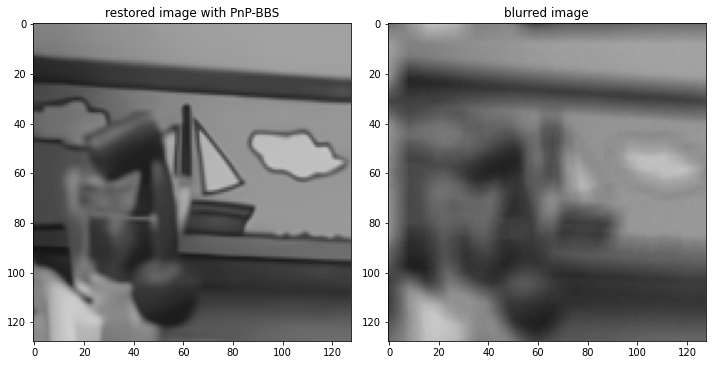

In [ ]:
# Run the algorithm
with torch.no_grad():
    start = time.time()
    out = pnp_bbs(blurredImage, model, prox_deblurring, **opts)
    end = time.time()

# Display results
displayResults(out, blurredImage, 'restored image with PnP-BBS', 'blurred image', 10, 10, end - start, u_orig)

1. Run the different algorithms for different values of $\alpha$ and number of iterations. What do you observe? 
2. Are the results of the three algorithms identical? Describe what you observe.
3. Display the graph of the PSNR values along the iterations for each algorithm and comment.  
4. How can we deal with the case $\sigma = 0$? 

### PnP for missing pixels

Everything works fine in the deblurring experiments above and all algorithms converge in a few dozens of iterations. We will now deal with an inverse problem where pixels are missing, and we will see that the same algorithms require much more iterations to converge.

We create the degraded image.

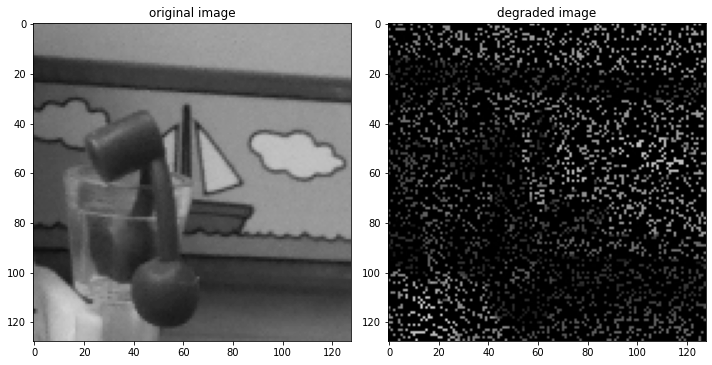

In [ ]:
#Create degraded image with 80% of missing pixels
sigma = 1/255    # noise level of the considered restoration problem      
degraded, mask = CreateImageWithMissingPixels(u_orig, sigma,0.8)

# Display the degraded image 
printImages(u_orig, degraded, 'original image', 'degraded image', 10, 10)

The following cell contains the gradient and proximal operators for the inpainting problem.

In [ ]:
#@title Gradient and proximal operators for inpainting
# Gradient step for inpainting
def grad_inpainting(x, im_b, **opts):
    """
    - Gradient Operator for Gaussian inpainting:
    f(x) = || M*x - im_b ||^2 / (2 sigma^2)
    
    Parameters:
        :x - the argument to the proximal operator.
        :im_b - the noisy observation.
        :mask - binary image of the same size as x
        :sigma - the standard deviation of the gaussian noise in im_b.
        :alpha - the regularization parameter.
    """
    alpha = opts.get('alpha', 1)
    sigma = opts.get('sigma', 1/255)
    mask_orig = opts.get('mask', np.ones_like(im_b))
    mask = np.reshape(mask_orig, -1)
    sigma_model = opts.get('sigma_model', 5)
    epsilon = (sigma_model/255)**2

    a = epsilon/(alpha*sigma**2)
    
    return x -a*(mask==1)*(x - im_b) 

# Proximal step for inpainting
def prox_inpainting(x, im_b, **opts):
    """
    Proximal Operator for Gaussian inpainting:
    f(x) = || M*x - im_b ||^2 / (2 sigma^2)
    prox_{alpha f} (x[i]) = (x[i] + im_b[i]*alpha/sigma^2)/(1+alpha/sigma^2) if M[i]==1
                          = x[i]                                             if M[i]==0
    Parameters:
        :x - the argument to the proximal operator.
        :im_b - the noisy observation.
        :mask - binary image of the same size as x
        :sigma - the standard deviation of the gaussian noise in im_b.
        :alpha - the regularization parameter.
    """

    alpha = opts.get('alpha', 1)
    sigma = opts.get('sigma', 1/255)
    mask_orig = opts.get('mask', np.ones_like(im_b))
    mask = np.reshape(mask_orig, -1)
    sigma_model = opts.get('sigma_model', 5)
    epsilon = (sigma_model/255)**2


    if sigma != 0:  
        a = epsilon/(alpha*sigma**2)
        out = (a*im_b + x)/(a+1)*mask + (1-mask)*x
    elif sigma == 0:
        out = mask*im_b + (1-mask)*x
    return np.copy(out)


In [ ]:
# Define the hyperparameters
alpha = 1  # weight of the data term   
maxitr = 1500 # number of iterations

# Kwargs for PnP algorithm
opts = dict(alpha=alpha, maxitr=maxitr, sigma_model=sigma_model, sigma=sigma, mask=mask)

1. Run the different algorithms for different values of $\alpha$ and number of iterations. What do you observe? 
2. Are the results of the three algorithms identical? Describe what you observe.
3.Display the graph of the PSNR values along the iterations for each algorithm and comment.
4. How can we deal with the case $\sigma = 0$? 

####PnADMM

time:  8.792715072631836
PSNR:  30.582656089672216


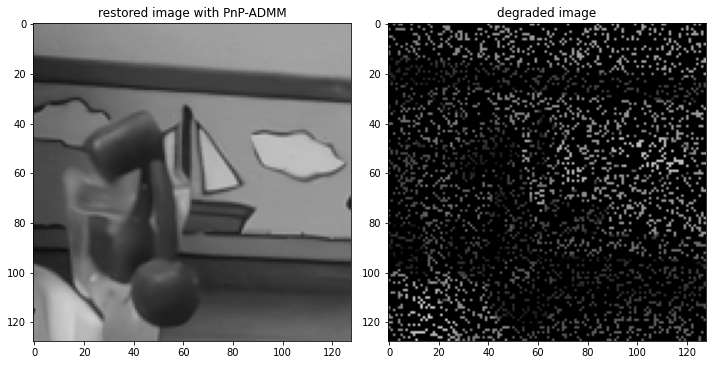

In [ ]:
# Run the ADMM algorithm
with torch.no_grad():
    start = time.time()
    out = pnp_admm(degraded, model, prox_inpainting, **opts)
    end = time.time()

# Display results
displayResults(out, degraded, 'restored image with PnP-ADMM', 'degraded image', 10, 10, end-start, u_orig)

#### PnP FBS



time:  7.231591701507568
PSNR:  27.842540887039032


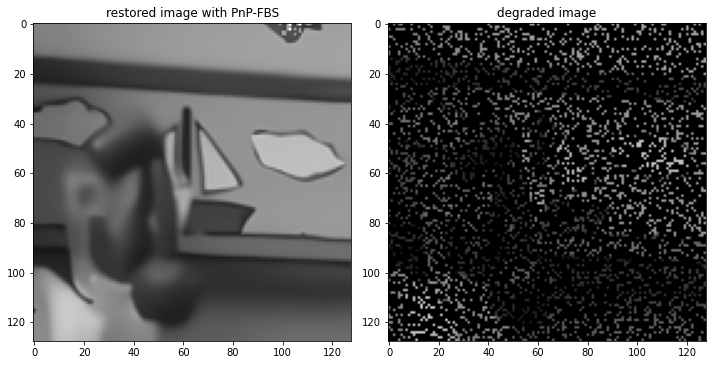

In [ ]:
# Run the algorithm
with torch.no_grad():
    start = time.time()
    out = pnp_fbs(degraded, model, prox_inpainting, **opts)
    end = time.time()

# Display results
displayResults(out, degraded, 'restored image with PnP-FBS', 'degraded image', 10, 10, end-start, u_orig)

#### PnP-BBS

time:  7.289088249206543
PSNR:  27.842540887039032


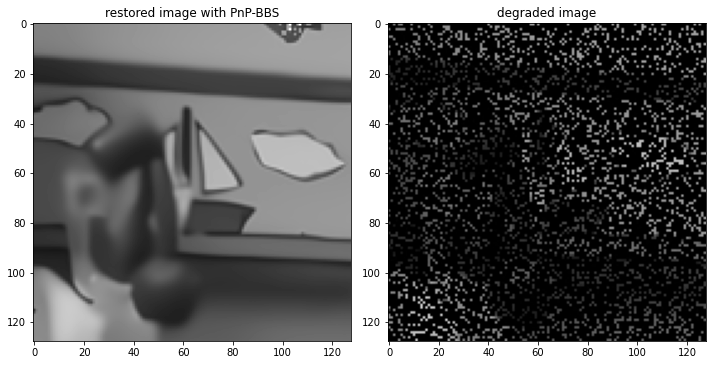

In [ ]:
# Run the algorithm
with torch.no_grad():
    start = time.time()
    out = pnp_bbs(degraded, model, prox_inpainting, **opts)
    end = time.time()

# Display results
displayResults(out, degraded, 'restored image with PnP-BBS', 'degraded image', 10, 10, end-start, u_orig)